The objective of this notebook is to develop a final model that is able to predict survival of people in heart failure. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_tr = pd.read_csv('X_tr.csv', index_col=0)

In [3]:
X_te = pd.read_csv('X_te.csv', index_col=0)

In [4]:
y_tr = pd.read_csv('y_tr.csv', index_col=0)

In [5]:
y_te = pd.read_csv('y_te.csv', index_col=0)

In [6]:
X_te.describe().T

,count,mean,std,min,25%,50%,75%,max
age,90.0,0.223911,1.075359,-1.733590,-0.609803,0.211425,0.859763,3.020890
creatinine_phosphokinase,90.0,-0.109003,0.892350,-0.567709,-0.490701,-0.374688,-0.032650,7.088144
ejection_fraction,90.0,0.083278,1.080021,-1.801434,-0.675227,0.017824,0.624243,3.656339
platelets,90.0,-0.040685,0.861104,-2.352836,-0.452921,-0.012246,0.367363,2.282996
serum_creatinine,90.0,0.133291,1.215980,-0.781635,-0.367589,-0.181269,0.149968,8.327371
serum_sodium,90.0,-0.111581,0.850978,-3.430633,-0.604366,-0.060853,0.265255,1.787091
time,90.0,-0.259330,1.058864,-1.745319,-1.236931,-0.391819,0.671175,1.780385
anaemia,90.0,0.377778,0.487548,0.000000,0.000000,0.000000,1.000000,1.000000
diabetes,90.0,0.344444,0.477849,0.000000,0.000000,0.000000,1.000000,1.000000
high_blood_pressure,90.0,0.411111,0.494792,0.000000,0.000000,0.000000,1.000000,1.000000


In [7]:
y_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
DEATH_EVENT,209.0,0.291866,0.455713,0.0,0.0,0.0,1.0,1.0


In [8]:
y_te.describe().T

,count,mean,std,min,25%,50%,75%,max
DEATH_EVENT,90.0,0.388889,0.490229,0.0,0.0,0.0,1.0,1.0


The training set contains 209 entries and the test set contains 90 entries. The data looks as expected.

In [9]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Feature ranking

Let's rank the features using Random Forest Regressor to determine which ones will be most influential in machine learning.

In [10]:
rf = RandomForestRegressor(random_state=1)
rf.fit(X_tr, y_tr.values.ravel());

In [11]:
features = X_tr.columns
features

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'diabetes',
       'high_blood_pressure', 'sex', 'smoking'],
      dtype='object')

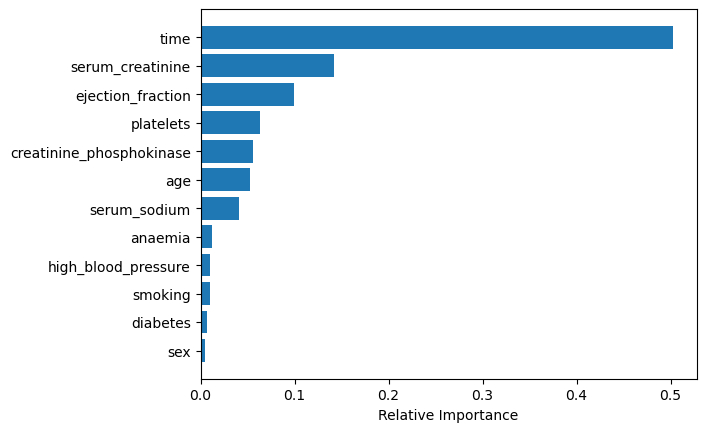

In [12]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.xlabel('Relative Importance')

plt.show()

Follow-up time is not a useful predictor -- it is likely that the sickest patients did not survive long for later follow-ups, while healthier patients had later follow-up times. It will be excluded from most analysis. Anemia, high blood pressure, smoking, diabetes, and sex do not appear to be strongly related to outcome. Serum creatinine and ejection fraction are likely indicators, and platelets, creatinine phosphokinase, age, and serum sodium are somewhat associated with outcome.

I'll create some different training/test sets with limited numbers of features and try them in various models as well as the full feature set excluding time.

## Create train/test sets

In [13]:
# Train/test set 1 
X_tr_1 = X_tr[['serum_creatinine','ejection_fraction']]
X_te_1 = X_te[['serum_creatinine','ejection_fraction']]

In [14]:
X_tr_1.describe()

,serum_creatinine,ejection_fraction
count,2.090000e+02,2.090000e+02
mean,1.211152e-16,-1.019918e-16
std,1.002401e+00,1.002401e+00
min,-8.851466e-01,-2.061328e+00
25%,-4.711009e-01,-6.752269e-01
50%,-2.640780e-01,1.782367e-02
75%,4.645633e-02,6.242429e-01
max,7.913326e+00,2.790026e+00


In [15]:
# Train/test set 2
X_tr_2 = X_tr[['serum_creatinine','ejection_fraction','platelets']]
X_te_2 = X_te[['serum_creatinine','ejection_fraction','platelets']]

In [16]:
#Train/test set 3
X_tr_3 = X_tr[['serum_creatinine','ejection_fraction','platelets','creatinine_phosphokinase']]
X_te_3 = X_te[['serum_creatinine','ejection_fraction','platelets','creatinine_phosphokinase']]

In [17]:
#Train/test set 4: all features except time
X_tr_4 = X_tr.drop('time', axis = 1)
X_te_4 = X_te.drop('time', axis = 1)

## Logistic regression

Logistic regression is used to predict a categorical dependent variable. In this case, it will predict patient survival.

In [18]:
#Build a logistic regression classifier and try it out on the dataset with all features except time

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)
classifier.fit(X_tr_4, y_tr.values.ravel())

y_predict_test = classifier.predict(X_te_4)
y_predict_training = classifier.predict(X_tr_4)

print(f'Accuracy on training data: {accuracy_score(classifier.predict(X_tr_4), y_tr):.2f}')
print(f'Accuracy on test data: {accuracy_score(classifier.predict(X_te_4), y_te):.2f}');

Accuracy on training data: 0.78
Accuracy on test data: 0.68


We need to take a look at the confusion matrix next to judge performance. This model is performing reasonably well on training data.

## Logistic regression confusion matrix

Confusion matrix, without normalization
[[46  9]
 [20 15]]
Normalized confusion matrix
[[0.84 0.16]
 [0.57 0.43]]


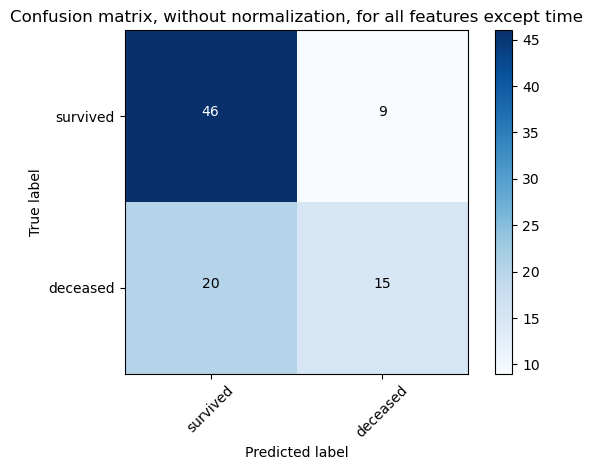

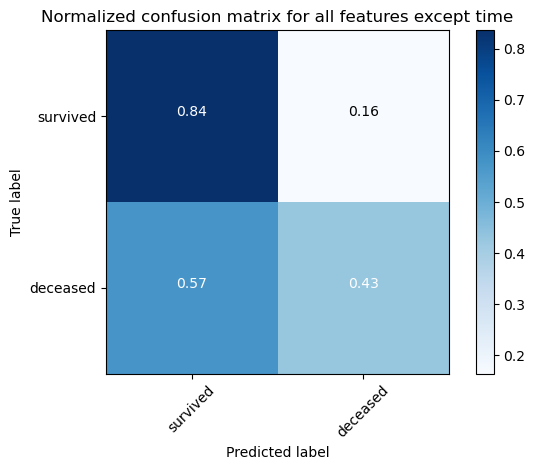

In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_predict_test)
class_names = ['survived', 'deceased']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_predict_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, for all features except time')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for all features except time')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Logistic regression using all features except time is correctly predicting survival 84% of the time and correctly predicting death events 43% of the time.


## Random forest classifier

Random forest classifiers can be used with large datasets where interpretability is not a priority. It is appropriate for both categorical and non-categorical predictions.

In [20]:
#Random forest classifier with full dataset except time (train/test set 4)
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_tr_4, y_tr.values.ravel())
y_pred_4 = model_res.predict(X_te_4)
y_pred_prob = model_res.predict_proba(X_te_4)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_te, y_pred_4)

f1 = f1_score(y_te, y_pred_4, average='weighted')
cm = confusion_matrix(y_te, y_pred_4)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.667
Random Forest: f1-score=0.653


The random forest model has a f1 score of 65% using all features except time.

In [21]:
#Random forest classifier with 4 features (X_tr_3)
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_tr_3, y_tr.values.ravel())
y_pred_3 = model_res.predict(X_te_3)
y_pred_prob = model_res.predict_proba(X_te_3)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_te, y_pred_3)

f1 = f1_score(y_te, y_pred_3, average='weighted')
cm = confusion_matrix(y_te, y_pred_3)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.744
Random Forest: f1-score=0.729


In [22]:
#Random forest classifier with 3 features (X_tr_2)
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_tr_2, y_tr.values.ravel())
y_pred = model_res.predict(X_te_2)
y_pred_prob = model_res.predict_proba(X_te_2)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_te, y_pred)

f1 = f1_score(y_te, y_pred, average='weighted')
cm = confusion_matrix(y_te, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.711
Random Forest: f1-score=0.699


In [23]:
#Random forest classifier with 2 features (X_tr_1)
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_tr_1, y_tr.values.ravel())
y_pred_1 = model_res.predict(X_te_1)
y_pred_prob = model_res.predict_proba(X_te_1)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_te, y_pred_1)

f1 = f1_score(y_te, y_pred_1, average='weighted')
cm = confusion_matrix(y_te, y_pred_1)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.678
Random Forest: f1-score=0.670


The random forest classifier performed best with 4 features and had an accuracy of 0.744. Accuracy is not a great measure of performance with imbalanced classes, however. Let's take a look at some of the confusion matrices for these feature sets.


## Confusion matrices for random forest

Confusion matrix, without normalization
[[45 10]
 [20 15]]
Normalized confusion matrix
[[0.82 0.18]
 [0.57 0.43]]


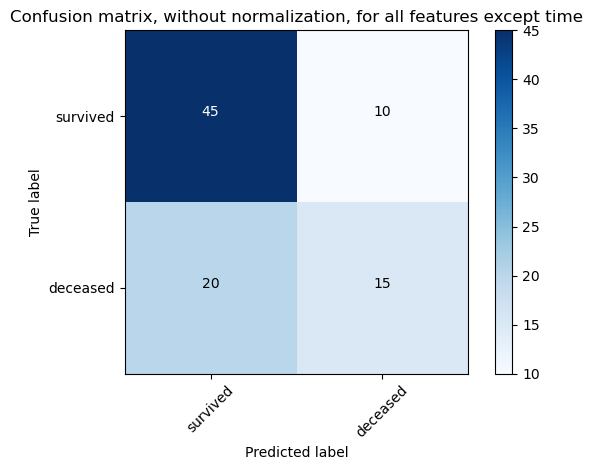

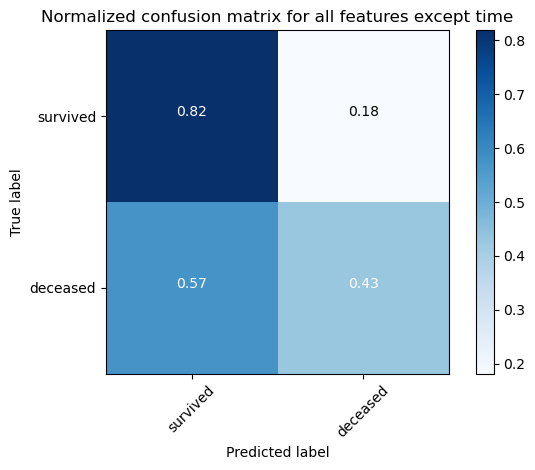

In [24]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred_4)
class_names = ['survived', 'deceased']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_pred_4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, for all features except time')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for all features except time')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Using all features except time, the random forest model predicted 82% of patient survival events and 43% of death events. It is expected that this model will perform less well in predicting death events on the test set because this outcome is more common in the test set than in the training set. Let's make a confusion matrix for the set of only 2 features. Let's look at the 4 feature dataset next.

Confusion matrix, without normalization
[[50  5]
 [18 17]]
Normalized confusion matrix
[[0.91 0.09]
 [0.51 0.49]]


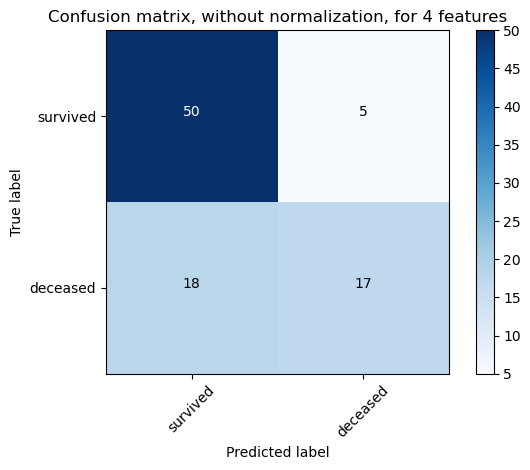

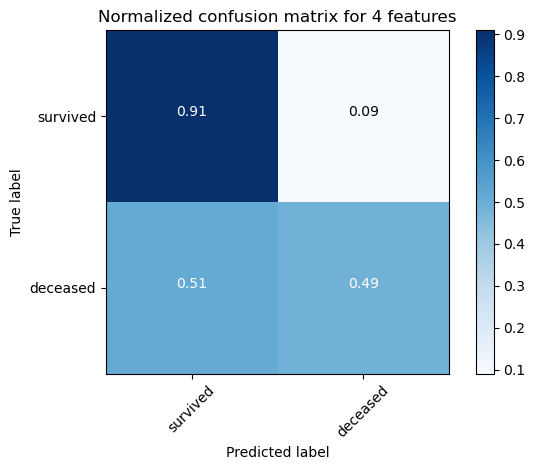

In [25]:
cm = confusion_matrix(y_te, y_pred_3)
class_names = ['survived', 'deceased']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_pred_3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, for 4 features')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for 4 features')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()


Given 4 features, the Random Forest model correctly predicted 91% of surviving patients and 49% of death events.

Confusion matrix, without normalization
[[44 11]
 [18 17]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.51 0.49]]


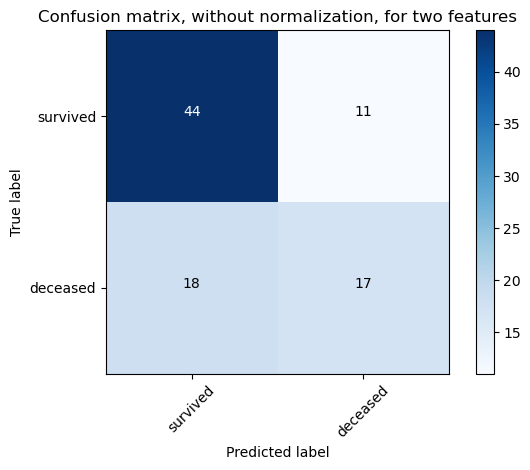

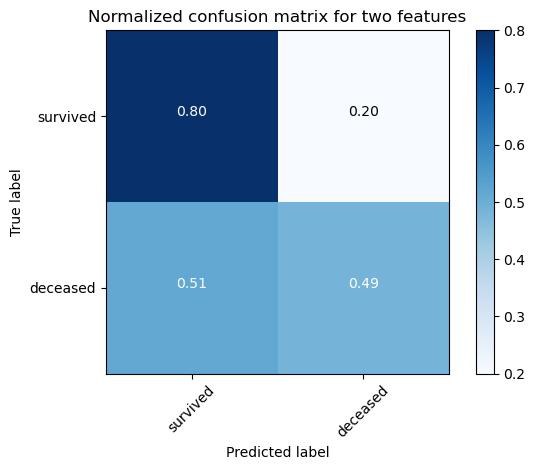

In [26]:
cm = confusion_matrix(y_te, y_pred_1)
class_names = ['survived', 'deceased']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_pred_1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, for two features')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for two features')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Using only 2 features, the classifier was right about patient survival 80% of the time and correctly predicted death events 49% of the time. So far, the 4 feature random forest model worked best.


## K Nearest Neighbors

K nearest neighbors uses a "majority vote" of the points nearest to the point of interest to determine an outcome. It can be used for classification and regression tasks.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# Try K nearest neighbors on full dataset except time

test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_tr_4,y_tr.values.ravel())
    
    train_scores.append(knn.score(X_tr_4,y_tr))
    test_scores.append(knn.score(X_te_4,y_te))


In [29]:
# Print train scores
for i in range(len(train_scores)):
  print(i+1,' ', train_scores[i])

print("The best k for training data was", train_scores.index(max(train_scores))+1)

1   1.0
2   0.7751196172248804
3   0.8181818181818182
4   0.784688995215311
5   0.7990430622009569
6   0.7655502392344498
7   0.7894736842105263
8   0.7703349282296651
9   0.7942583732057417
The best k for training data was 1


In [30]:
# Print test scores
for i in range(len(test_scores)):
  print(i+1,' ', test_scores[i])

print("The best k for test data was", test_scores.index(max(test_scores))+1)

1   0.6777777777777778
2   0.6444444444444445
3   0.7111111111111111
4   0.6555555555555556
5   0.6888888888888889
6   0.6444444444444445
7   0.6777777777777778
8   0.6555555555555556
9   0.6666666666666666
The best k for test data was 3


/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

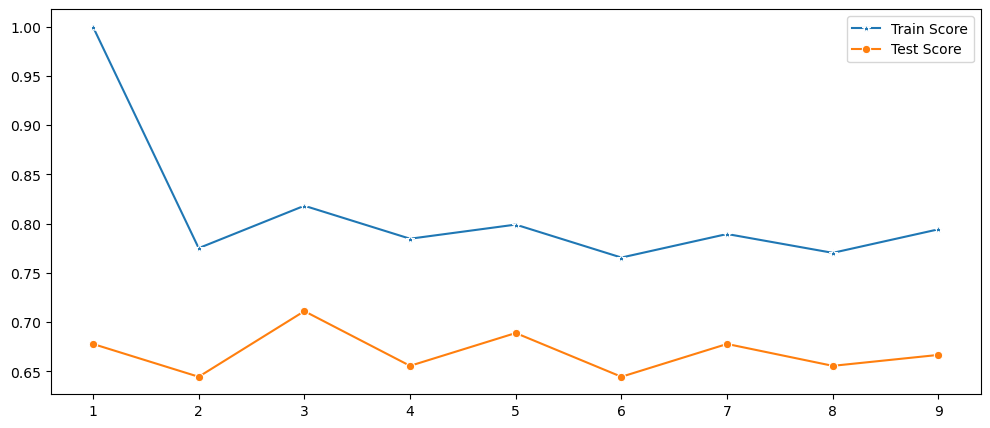

In [31]:
# Plot the scores

plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,10),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,10),y=test_scores,marker='o',label='Test Score')

k = 3 yields the best result.

In [32]:
knn = KNeighborsClassifier(3)
knn.fit(X_tr_4,y_tr.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [33]:
y_pred_4 = knn.predict(X_te_4)

Confusion matrix, without normalization
[[48  7]
 [19 16]]
Normalized confusion matrix
[[0.87 0.13]
 [0.54 0.46]]


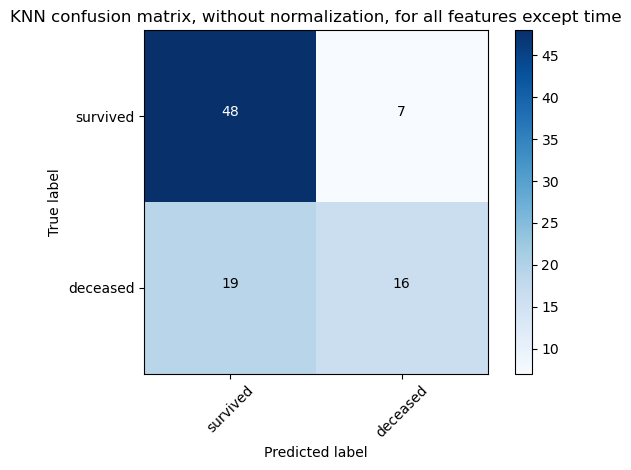

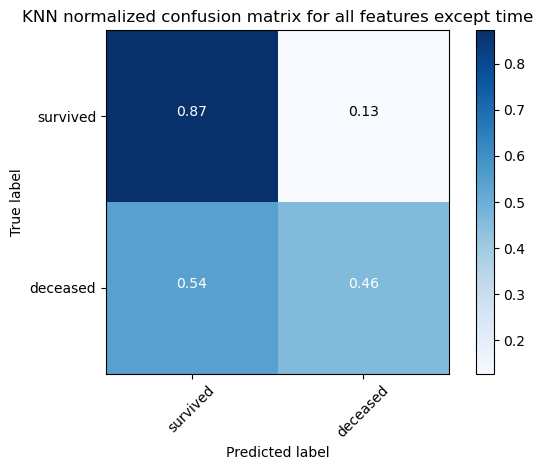

In [34]:
cm = confusion_matrix(y_te, y_pred_4)
class_names = ['survived', 'deceased']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_pred_4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='KNN confusion matrix, without normalization, for all features except time')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='KNN normalized confusion matrix for all features except time')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Using all features except time, k nearest neighbors was able to correctly predict survival 87% of the time and death 46% of the time. Let's try it with 4 features too.

In [35]:
# Try K nearest neighbors on 4 feature dataset

test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_tr_3,y_tr.values.ravel())
    
    train_scores.append(knn.score(X_tr_3,y_tr))
    test_scores.append(knn.score(X_te_3,y_te))

In [36]:
# Print train scores
for i in range(len(train_scores)):
  print(i+1,' ', train_scores[i])

print("The best k for training data was", train_scores.index(max(train_scores))+1)

1   1.0
2   0.8229665071770335
3   0.8325358851674641
4   0.7990430622009569
5   0.8133971291866029
6   0.8038277511961722
7   0.784688995215311
8   0.7894736842105263
9   0.7894736842105263
The best k for training data was 1


In [37]:
# Print test scores
for i in range(len(test_scores)):
  print(i+1,' ', test_scores[i])

print("The best k for test data was", test_scores.index(max(test_scores))+1)

1   0.6666666666666666
2   0.6333333333333333
3   0.6666666666666666
4   0.6666666666666666
5   0.6666666666666666
6   0.6666666666666666
7   0.6666666666666666
8   0.6888888888888889
9   0.6777777777777778
The best k for test data was 8


/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jgehring/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

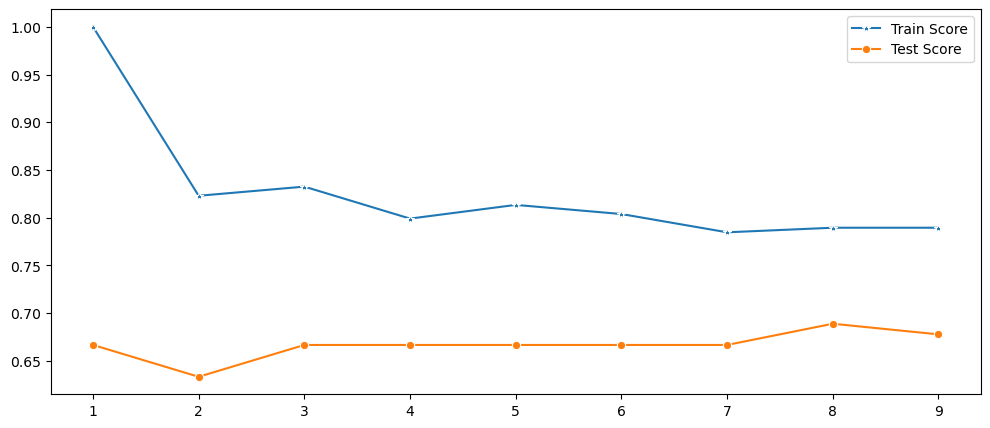

In [38]:
# Plot the scores

plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,10),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,10),y=test_scores,marker='o',label='Test Score')

k = 3 looks like a good option again

In [39]:
knn = KNeighborsClassifier(3)
knn.fit(X_tr_3,y_tr.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [40]:
y_pred_3 = knn.predict(X_te_3)

Confusion matrix, without normalization
[[48  7]
 [23 12]]
Normalized confusion matrix
[[0.87 0.13]
 [0.66 0.34]]


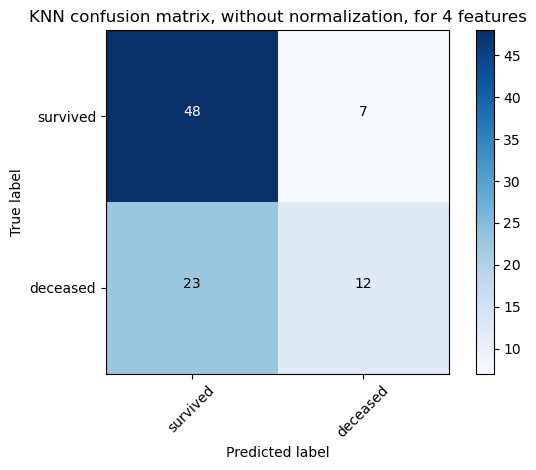

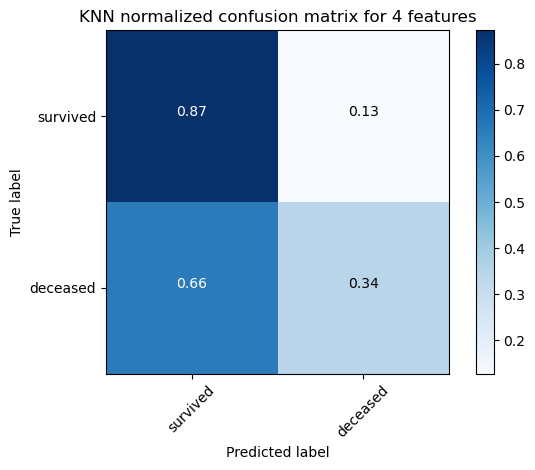

In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_pred_3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='KNN confusion matrix, without normalization, for 4 features')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='KNN normalized confusion matrix for 4 features')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

With a 4-feature dataset the model performed well on predicting survival but abysmally on predicting death outcomes.

Out of all models attempted, the random forest model performed the best paired with the 4 feature dataset, correctly predicting 91% of survival outcomes and 49% of deaths.